# Figure 1
This is a side-by-side plot of the flight tracks from the campaign with a satellite image showing a typical cold-air outbreak from the campaign. 

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
from matplotlib.patches import Patch
import cdsapi

In [2]:
NPS = ccrs.NorthPolarStereo(central_longitude=15)
PC = ccrs.PlateCarree()

In [3]:
def create_map_basis(ax):
    ax.set_extent([0, 30, 66, 82], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=PC, zorder=6, draw_labels=True, x_inline = False,
                      y_inline = False, linewidth=0.5, linestyle=(0, (5, 1)))
    gl.n_steps = 60
    gl.ylocator = mticker.FixedLocator(np.arange(60, 90, 2))
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(-20, 61, 5))
    gl.xformatter = LONGITUDE_FORMATTER
    
    gl.ylabel_style = {'fontsize': 10, 'zorder': 6, 'rotation':0, 'color': 'k'}
    gl.xlabel_style = {'fontsize': 10, 'zorder': 6, 'rotation':0, 'color': 'k'}
    gl.top_labels = False
    gl.right_labels = False

In [4]:
def make_map_elements(ax,add=True):
    # Find paths to the sea-ice shapefiles for the maximum and minimum sea-ice extent
    max_ice_path = '/home/users/erinraif/acao_data/sea_ice_shapefiles/20220311_c271/masie_ice_r00_v01_2022070_1km.shp'
    min_ice_path = '/home/users/erinraif/acao_data/sea_ice_shapefiles/20220330_c281_c282/masie_ice_r00_v01_2022089_1km.shp'
    
    # define the coastlines, oceans and land shapes
    coasts_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', 
                                              edgecolor='black',
                                              facecolor= 'none')
    
    ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                            edgecolor='face',
                                            facecolor='lightblue')
    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='lightgray')
    
    # Create sea-ice features
    max_ice = cfeature.ShapelyFeature(Reader(max_ice_path).geometries(),
                                             ccrs.NorthPolarStereo(central_longitude = -80, 
                                             true_scale_latitude = 60), facecolor = 'azure',
                                             edgecolors = 'red', linestyle='--')
    
    min_ice = cfeature.ShapelyFeature(Reader(min_ice_path).geometries(),
                                             ccrs.NorthPolarStereo(central_longitude = -80, 
                                             true_scale_latitude = 60), facecolor = 'azure',
                                             edgecolors = 'red', linestyle='-')
    
    # add all to the map
    if add:
        ax.add_feature(ocean_50m, zorder = 1, alpha = 0.4)
        ax.add_feature(max_ice, zorder = 3, linewidth = 0.5)
        ax.add_feature(min_ice, zorder = 2, linewidth = 0.5)
        ax.add_feature(land_50m, zorder = 4, alpha = 0.4)
        ax.add_feature(coasts_50m, zorder = 5, linewidth = 0.5)

In [5]:
def plot_flight_track(flight_id,ax,**kwargs):
    flight_data = xr.open_dataset(
                    glob('/badc/faam/data/2022/'+
                         flight_id+'*/core_processed/core_faam*'
                         +flight_id+'.nc')[-1], decode_times=False, engine='netcdf4')
    ax.plot(flight_data.LON_GIN[:,0], flight_data.LAT_GIN[:,0],
        transform = PC, **kwargs)
    return
    

In [6]:
# Retreieve reanalysis data at the appropriate time, save to NetCDF and read.
# DONT FORGET YOUVE CHANGED THIS FROM 30th at 11am!!!!!!!!!!!!
c = cdsapi.Client()
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': 'mean_sea_level_pressure',
        'year': '2022',
        'month': '03',
        'day': '30',
        'time': '11:00',
        'area': [ #NWSE
            82.5, -25, 66,
            55, 
        ],
        'format': 'netcdf',
    },
    r'./era5_data/fig1_pressure0330_data.nc')
pressure_data = xr.open_dataset(r'./era5_data/fig1_pressure0330_data.nc')
pressure_data

2024-05-12 19:10:29,760 INFO Welcome to the CDS
2024-05-12 19:10:29,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-05-12 19:10:29,844 INFO Request is completed
2024-05-12 19:10:29,845 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data0/adaptor.mars.internal-1715540840.6491206-27309-15-c9101b2d-e2e3-4765-8ac5-1d2fc3e925c3.nc to ./era5_data/fig1_pressure0330_data.nc (44.6K)
2024-05-12 19:10:30,131 INFO Download rate 156.8K/s


<xarray.Dataset>
Dimensions:    (longitude: 321, latitude: 67, time: 1)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 54.5 54.75 55.0
  * latitude   (latitude) float32 82.5 82.25 82.0 81.75 ... 66.5 66.25 66.0
  * time       (time) datetime64[ns] 2022-03-30T11:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-12 19:07:20 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

**Weird error that some people may have to correct** *(it's the only one, I promise!)*. NASA seemingly changed their server-side handling of WMTS objects which made wmts.py in OWSLib stop working in all versions after I'd already made this figure! To make it work, you need to change line 236 in OWSLib/wmts.py to remove the RaiseError and replace with a warning 

```
msg = ('Content metadata for layer "%s" '
        'already exists' % cm.id)
                            
warnings.warn(msg, RuntimeWarning)
```

/home/users/erinraif/nb_envs/acao_fig_basic/lib/python3.10/site-packages/owslib/wmts.py:646: RuntimeWarning: TileMatrixLimits with tileMatrix "1" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/acao_fig_basic/lib/python3.10/site-packages/owslib/wmts.py:646: RuntimeWarning: TileMatrixLimits with tileMatrix "2" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/acao_fig_basic/lib/python3.10/site-packages/owslib/wmts.py:646: RuntimeWarning: TileMatrixLimits with tileMatrix "3" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/acao_fig_basic/lib/python3.10/site-packages/owslib/wmts.py:646: RuntimeWarning: TileMatrixLimits with tileMatrix "4" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/acao_fig_basic/lib/python3.10/site-packages/owslib/wmts.py:646: RuntimeWarning: TileMatrixLimits with tileMatrix "5" already exists
  warnings.warn(msg, RuntimeWarning)
/home/user

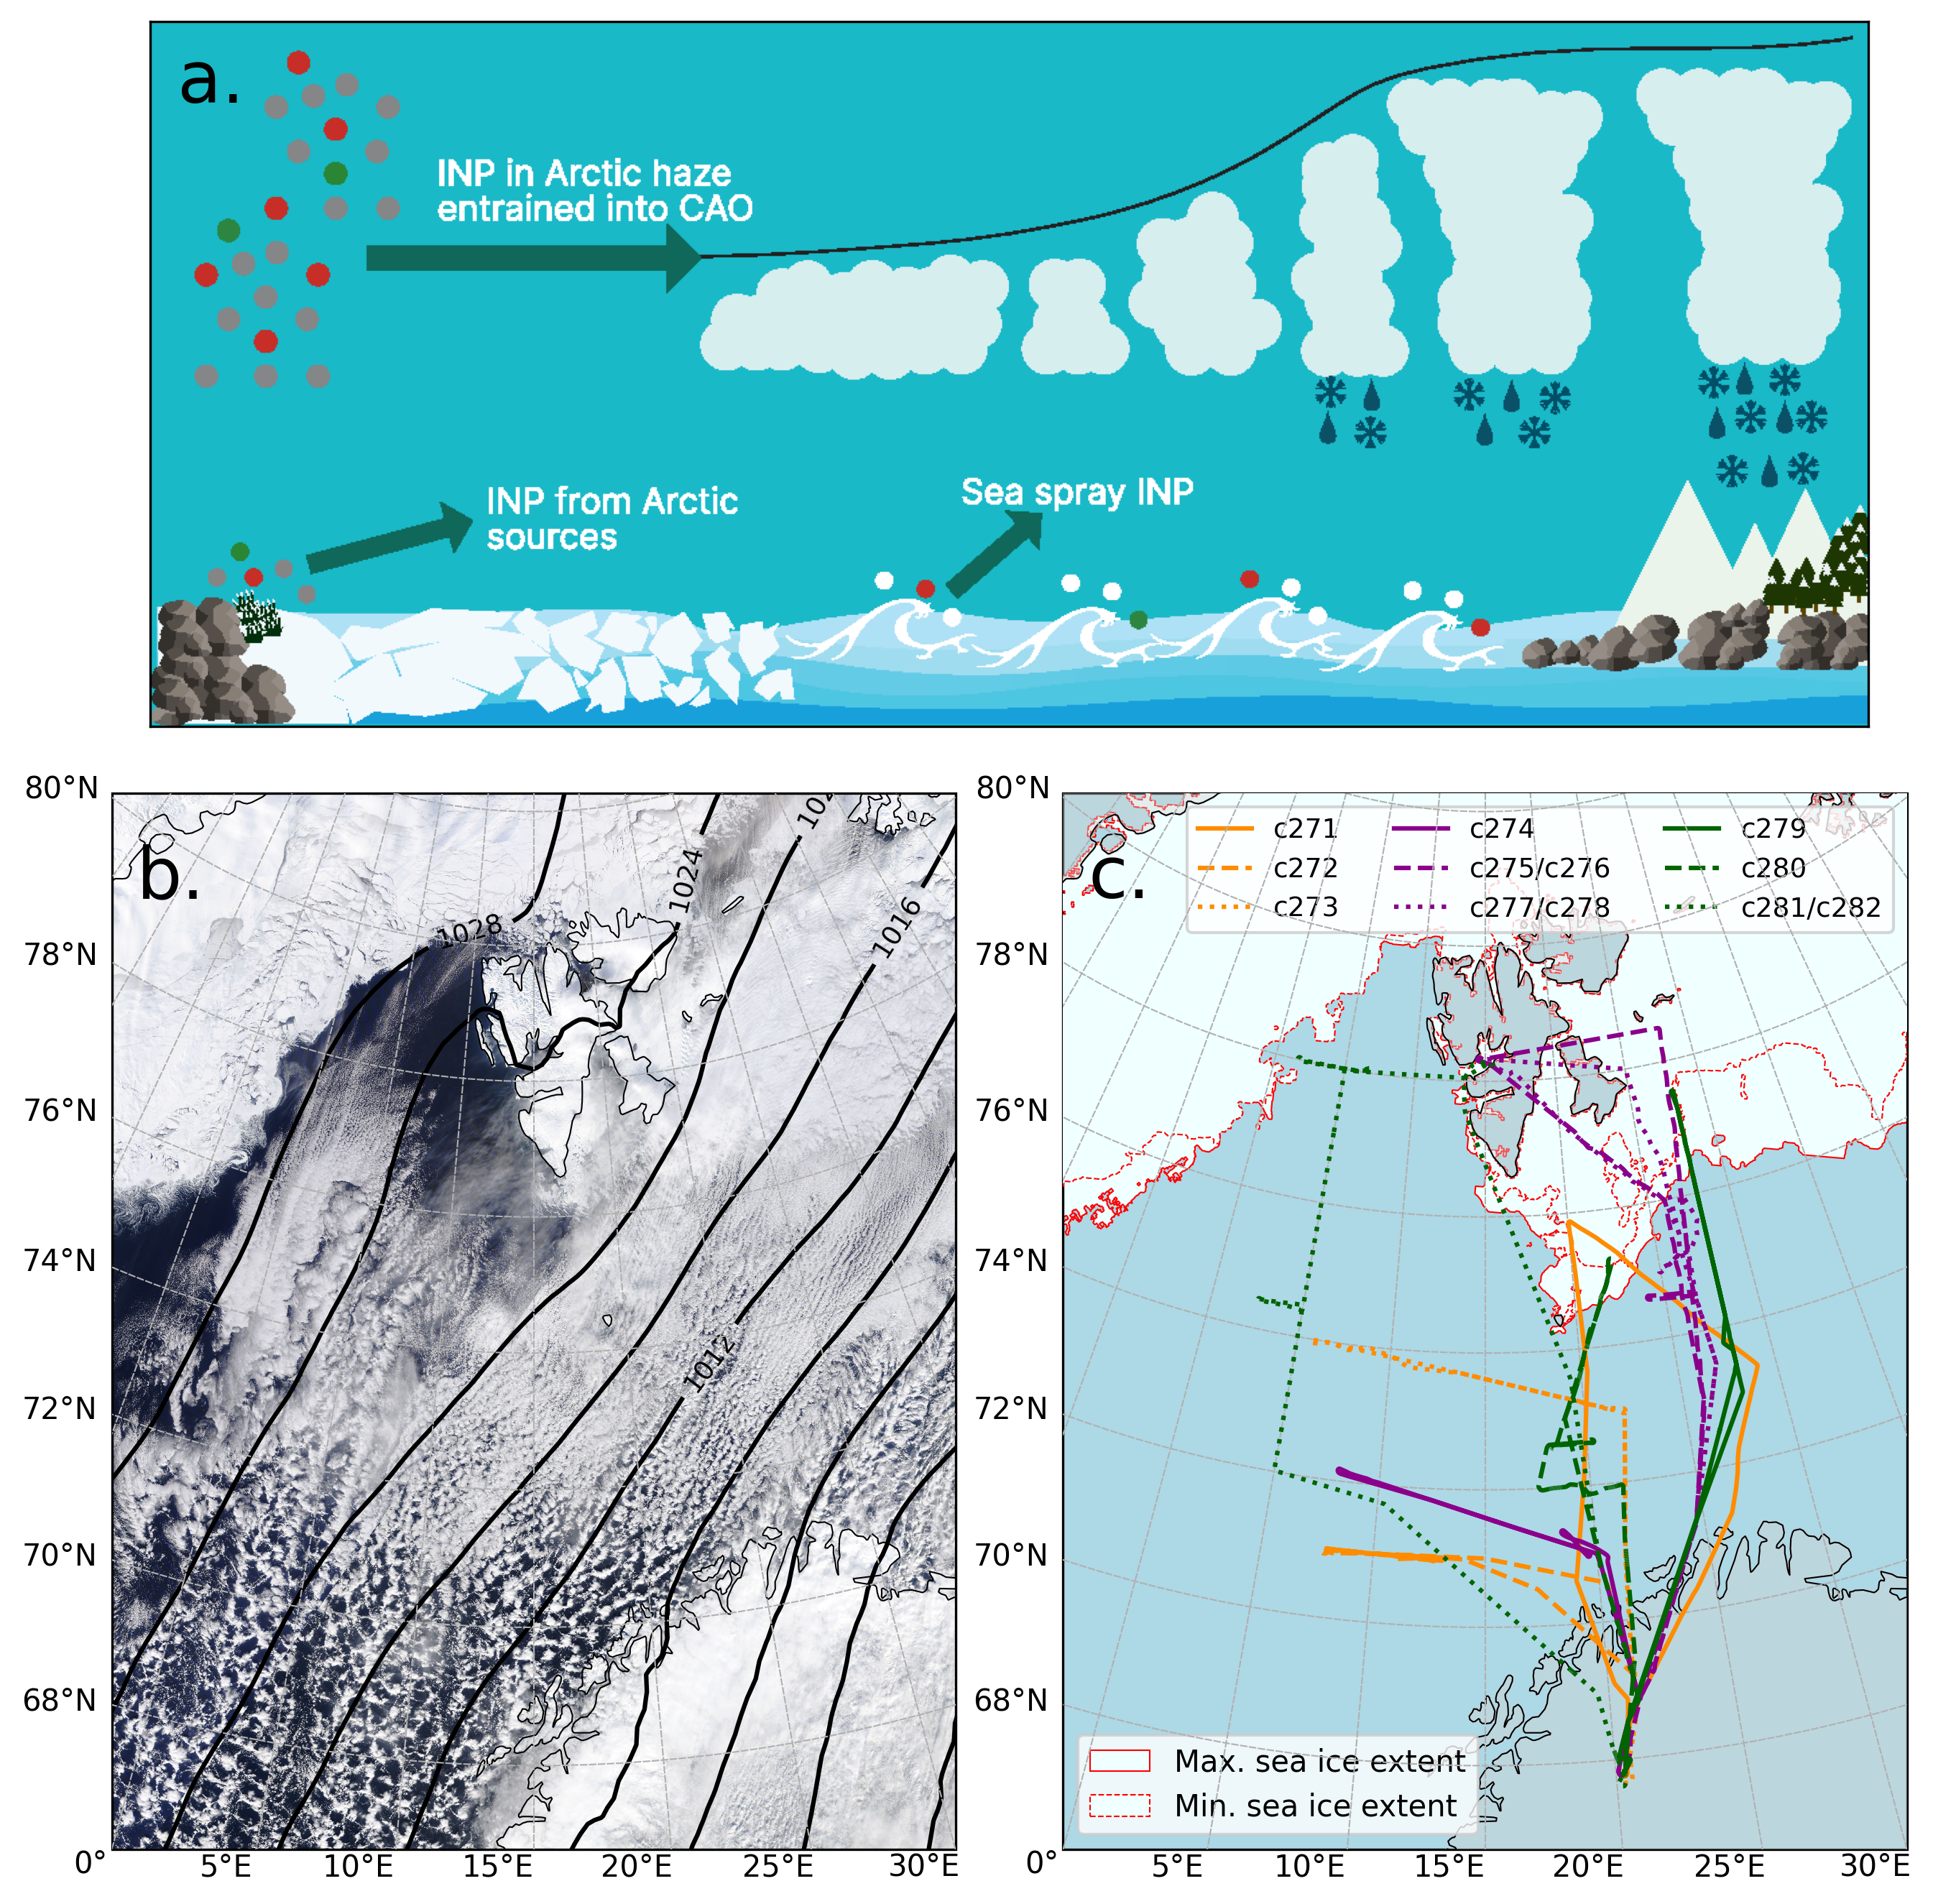

In [7]:
# Note that this needs matplotlib 3.7 or later for per_subplot_kw to work
# Axes have strange labels, I know, because I started with C at the bottom and B on the left.
pressure_data = xr.open_dataset(r'./era5_data/fig1_pressure0330_data.nc')
fig, axes = plt.subplot_mosaic(
            """
            CCCC
            CCCC
            BBAA
            BBAA
            BBAA
            """,
            figsize=(9,9), dpi=300,
            per_subplot_kw = {
                ("A","B"): {'projection': NPS}
            })

# Add sketch to bottom axes and remove ticks as not a graph
im_C = plt.imread('sketches/cao_schematic_V2.eps')
axes['C'].imshow(im_C)
axes['C'].set_xticks([])
axes['C'].set_yticks([])

#Retrieve satellite imagery
dateiso = '2022-03-30'
product = 'MODIS_Terra_CorrectedReflectance_TrueColor'
wmt_url = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
#Add Satellite Imagery

for ax in [axes['A'], axes['B']]:
#for ax in [axes['B']]:
    create_map_basis(ax)
axes['B'].add_wmts(wmt_url, product, wmts_kwargs={'time': dateiso})


make_map_elements(axes['A'])

#Plot flight tracks, only labelling the first of each double-flight.
plot_flight_track('c271',axes['A'],linewidth = 1.5, linestyle='-',
                  color='darkorange', zorder = 7, label='c271')
plot_flight_track('c272',axes['A'],linewidth = 1.5, linestyle='--',
                  color='darkorange', zorder = 8, label='c272')
plot_flight_track('c273',axes['A'],linewidth = 1.5, linestyle=':',
                  color='darkorange', zorder = 9, label='c273')
plot_flight_track('c274',axes['A'],linewidth = 1.5, linestyle='-',
                  color='darkmagenta', zorder = 10, label='c274')
plot_flight_track('c275',axes['A'],linewidth = 1.5, linestyle='--',
                  color='darkmagenta', zorder = 11, label='c275/c276')
plot_flight_track('c276',axes['A'],linewidth = 1.5, linestyle='--',
                  color='darkmagenta', zorder = 11)
plot_flight_track('c277',axes['A'],linewidth = 1.5, linestyle=':',
                  color='darkmagenta', zorder = 12, label='c277/c278')
plot_flight_track('c278',axes['A'],linewidth = 1.5, linestyle=':',
                  color='darkmagenta', zorder = 12)
plot_flight_track('c279',axes['A'],linewidth = 1.5, linestyle='-',
                  color='darkgreen', zorder = 13, label='c279')
plot_flight_track('c280',axes['A'],linewidth = 1.5, linestyle='--',
                  color='darkgreen', zorder = 14, label='c280')
plot_flight_track('c281',axes['A'],linewidth = 1.5, linestyle=':',
                  color='darkgreen', zorder = 15, label='c281/c282')
plot_flight_track('c282',axes['A'],linewidth = 1.5, linestyle=':',
                  color='darkgreen', zorder = 12)

legend1 = axes['A'].legend(loc="upper right",ncol=3,fontsize=9)

# Keep legend permanently as-is
axes['A'].add_artist(legend1)

second_legend_elements = [
    Patch(facecolor='azure', edgecolor='red', linestyle='-', linewidth=0.5,
          label='Max. sea ice extent'),
    Patch(facecolor='azure', edgecolor='red', linestyle='--', linewidth=0.5,
          label='Min. sea ice extent'),
]

legend2 = axes['A'].legend(handles=second_legend_elements, loc='lower left',fontsize=10)

coasts_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                      edgecolor='black',
                                      facecolor='none')
axes['B'].add_feature(coasts_50m, linewidth=0.5)

lats = pressure_data['latitude'].values
lons = pressure_data['longitude'].values
pressure = pressure_data['msl'].values[0]/100 #hPa

# Define the levels for the isobars
pressure_levels = np.arange(980,1050,4)

# Create a contour plot on ax2
contour = axes['B'].contour(lons, lats, pressure, levels=pressure_levels, colors='k', transform=ccrs.PlateCarree())
clabels = plt.clabel(contour, inline=True, fontsize=9, fmt='%d',inline_spacing=5)

axes['A'].text(-17.5,79,"c.",size=24,transform=PC)
axes['B'].text(-17.5,79,"b.",size=24,transform=PC)
axes['C'].text(20,60,"a.",size=24)
fig.tight_layout()
fig.savefig('./imgs/f01.png')